## MLP Training With Backpropagation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from graphviz import Digraph

## Visualizing nodes

In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label ,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## MicroGrad

In [4]:
class Value:
    def __init__(self, data: int, _children: tuple = (), _op: str="", label: str=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # because we are not calculating gradient for leaf value

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        """get the other value, add to this value and return a new value"""
        other = other if isinstance(other, Value) else Value(other) # if other is not a value, convert it to value
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
          self.grad += 1.0 * out.grad # for + it is just a gradient distributor
          other.grad += 1.0 * out.grad # so the grad for the value will be the grad of the output
        out._backward = _backward # later can call this function to calculate it when needed to calculate
        return out
      
    def __rmul__(self, other): # if given 2*instance_a, it will call instance_a.__rmul__(2)
      return self*other

    def __mul__(self, other): # instance_a.__mul__(instance_b)
        other = other if isinstance(other, Value) else Value(other) # if other is not a value, convert it to value
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad # chain rule

        out._backward = _backward # will later call this when needed

        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
          self.grad += (1 - t**2) * out.grad # local derivative * out grad
        out._backward = _backward # for tanh the derivative is (1-tanh(n)**2)
        return out

    def backward(self):
      topo = []
      visited = set()

      def topo_sort(v):
        # check the visited node and add if not visited
         if v not in visited:
          visited.add(v)
          # check the child node
          for child in v._prev:
            topo_sort(child)
          # append after traversing all child node
          topo.append(v)
      # build topo graph
      topo_sort(self)

      self.grad = 1.0 # gradient of last node is 1.0

      for node in reversed(topo): # call each node backpropagation from last node in order
        node._backward()


In [5]:
x1 = Value(2.0, label="x1") # input 1
x2 = Value(0.0, label="x2") # input 2

w1 = Value(-3.0, label="w1") # weight 1
w2 = Value(1.0, label="w2") # weight 2
b = Value(6.8813735870195432, label="b") # bias 1

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label = "o"

# input1:  O>
#      w1 and w2 and bias      O ->   tanh(n) -> output
# input2: O>

In [6]:
o.backward()

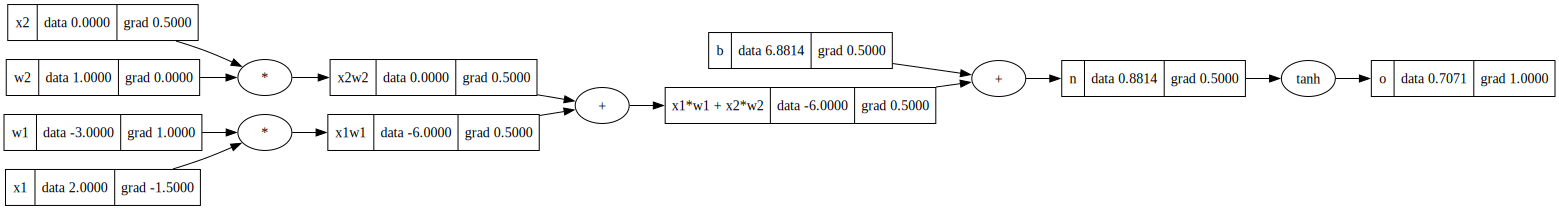

In [7]:
draw_dot(o)

In [8]:
a = Value(2.0, label="a")
a = a + 1

a

Value(data=3.0)

In [9]:
a = Value(2.0, label="a")
a = a * 3 # but we cannot do 3 * a for thi we need __rmul__

a

Value(data=6.0)

In [10]:
2 * a

Value(data=12.0)

## Tanh expression

In [11]:
class Value:
    def __init__(self, data: int, _children: tuple = (), _op: str="", label: str=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # because we are not calculating gradient for leaf value

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        """get the other value, add to this value and return a new value"""
        other = other if isinstance(other, Value) else Value(other) # if other is not a value, convert it to value
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
          self.grad += 1.0 * out.grad # for + it is just a gradient distributor
          other.grad += 1.0 * out.grad # so the grad for the value will be the grad of the output
        out._backward = _backward # later can call this function to calculate it when needed to calculate
        return out
    
    def __neg__(self):
        return self * -1 # negation when called on instance
    
    def __sub__(self, other):
        return self + (-other) # will call negation
      
    def __rmul__(self, other): # if given 2*instance_a, it will call instance_a.__rmul__(2)
      return self*other

    def __mul__(self, other): # instance_a.__mul__(instance_b)
        other = other if isinstance(other, Value) else Value(other) # if other is not a value, convert it to value
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad # chain rule

        out._backward = _backward # will later call this when needed

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad # derivative of x^n is n*x^(n-1)
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1 # a/b : a * 1/b : a * b^-1

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
          self.grad += (1 - t**2) * out.grad # local derivative * out grad
        out._backward = _backward # for tanh the derivative is (1-tanh(n)**2)
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
      topo = [] 
      visited = set()

      def topo_sort(v):
        # check the visited node and add if not visited
         if v not in visited:
          visited.add(v)
          # check the child node
          for child in v._prev:
            topo_sort(child)
          # append after traversing all child node
          topo.append(v)
      # build topo graph
      topo_sort(self)

      self.grad = 1.0 # gradient of last node is 1.0

      for node in reversed(topo): # call each node backpropagation from last node in order
        node._backward()


In [12]:
a = Value(2.0, label="a")
a.exp()

Value(data=7.38905609893065)

In [13]:
a = Value(2.0, label="a")
b = Value(3.0, label="b")

a / b

Value(data=0.6666666666666666)

In [14]:
a - b

Value(data=-1.0)

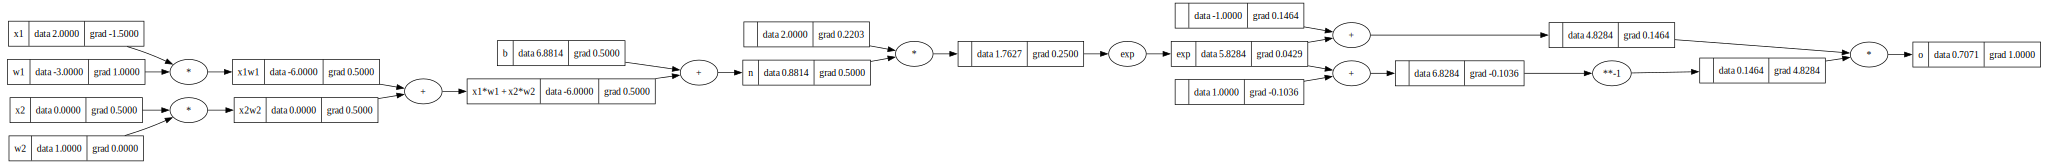

In [15]:
x1 = Value(2.0, label="x1") # input 1
x2 = Value(0.0, label="x2") # input 2

w1 = Value(-3.0, label="w1") # weight 1
w2 = Value(1.0, label="w2") # weight 2

b = Value(6.8813735870195432, label="b") # bias 1

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label="n"

# for tanh
e = (2*n).exp(); e.label = "exp" # tanh(x) = sinhx/coshx = (e^x - e^-x) / (e^x + e^-x) = (e^2x - 1) / (e^2x + 1)
o = (e - 1) / (e + 1); o.label="o"

o.backward()
draw_dot(o)

## Doing the same thing with Pytorch

In [16]:
import torch

x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0],).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(f"X1: {x1.grad.item()}")
print(f"W1: {w1.grad.item()}")
print(f"X2: {x2.grad.item()}")
print(f"W2: {w2.grad.item()}")

0.7071066904050358
X1: -1.5000003851533106
W1: 1.0000002567688737
X2: 0.5000001283844369
W2: 0.0


## MLP

In [17]:
np.random.uniform(-10, 10, 10)

array([ 7.18803644, -9.2080123 ,  4.14206596, -4.92689692, -7.35161332,
       -9.82355492, -9.05622445,  1.28983872,  0.72000978, -2.07123042])

In [18]:
import random

random.uniform(-1,2)

1.0186032606255075

In [19]:
sum([2,2,3],1)

8

### A single Neuron

In [20]:
random.seed(2) # get the same random number

class Neuron:
    def __init__(self, nin: int):
        """Creates a neuron
        
        Args:
           - nin: numbr of input to neuron
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights of a neuron associated along each input
        self.b = Value(random.uniform(-1,1)) # bias of a neuron
        
    def __call__(self, x):
        # when called on its instance, this function is called
        act = sum((wi * xi for wi, xi in zip(self.w, x)) , self.b) # w1*x1 + w2*x2 + ... + b
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(len(x)) # neuron with 2 input
n(x) # after forward propagation

Value(data=0.9985784015367755)

### Layer of a MLP

In [21]:
class Layer:
    """creates a layer of neurons in a MLP
    
    arg:
       - nin: number of input to each neuron
       - nout: number of neurons in a layer
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # create nout neurons with nin input per neuron
        
    def __call__(self, x):
        outs =  [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # get only the output if the layer is only one
    
l = Layer(2, 1) # a single layer network with 2 input and a single output
x = [2.0, 3.0]

l(x) # output of a layer

Value(data=0.6774690870937001)

In [22]:
l = Layer(2, 3)
l(x)

[Value(data=-0.25464280547824913),
 Value(data=0.22716368041083768),
 Value(data=-0.43828524378857286)]

### MLP

In [23]:
nin = 3
nouts = [4, 8, 1]
sz = [nin] + nouts
sz

[3, 4, 8, 1]

In [24]:
for i in range(len(nouts)): # 0, 1, 2
    print(f"Layer {i+1}: Input : {sz[i]} and Output: {sz[i+1]}")

Layer 1: Input : 3 and Output: 4
Layer 2: Input : 4 and Output: 8
Layer 3: Input : 8 and Output: 1


In [25]:
[Layer(sz[i], sz[i+1]) for i in range(len(nouts))] 

In [26]:
class MLP:
    """creates a multi-layer perceptron network
    
    Args:
        - nin: number of input to the network
        - nouts: number of neurons in each layer [4, 4, 1] for 4 neuron in 1st and 2nd layer and 1 neuron in output layer
    """
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts # concatenate the input and output size of mlp
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # create a layer with input and output size matching to the mlp
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1]) # an MLP with 3 input, and 3 layers with hidden layer 1 : 4 neuron, hidden layer 2: 4 neuron and output layer with a single neuron
n(x)
    

Value(data=-0.03887414218404339)

## Training with our MLP

In [27]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # because our activation function is tanh

In [28]:
y_pred = [n(x) for x in xs] # each input in out MLP with 3 input size 2 hidden layer of 4 neuron and 1 output
y_pred

[Value(data=-0.9806871718162673),
 Value(data=-0.5698711665959351),
 Value(data=-0.8481951710605788),
 Value(data=-0.9652615208078065)]

In [29]:
def mse(y_pred: list, y_true: list):
    """calculates mean squared error"""
    total = Value(0.0)
    for yp, yt in zip(y_pred, y_true):
        total = total +  (yp - yt)**2 # mse loss calculation
    return total / len(y_true)

In [30]:
mse([2, 2], [2, 2]), mse([3, 1], [0, 0])

(Value(data=0.0), Value(data=5.0))

In [31]:
loss = mse(y_pred, ys)
loss

Value(data=1.9983575092950514)

In [32]:
loss.backward()

In [33]:
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[1].grad

(-0.008875954044088521, -0.01643004885646219)

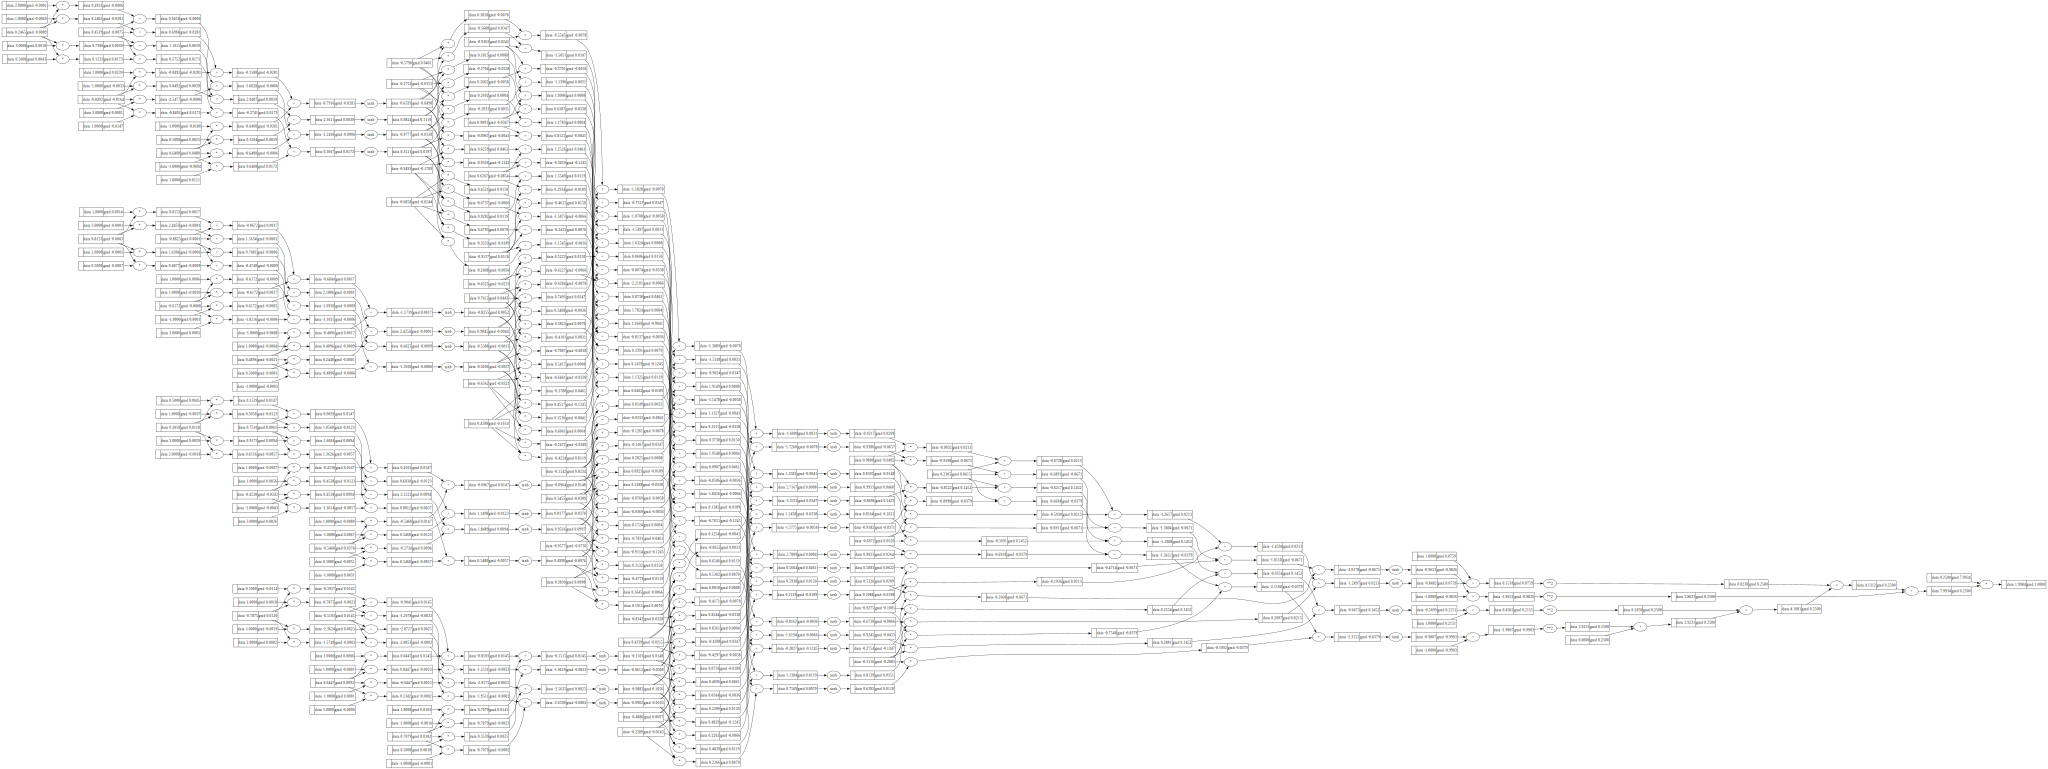

In [34]:
draw_dot(loss)

## Creating a Full Training with Backpropagation

In [35]:
class Neuron:
    def __init__(self, nin: int):
        """Creates a neuron
        
        Args:
           - nin: numbr of input to neuron
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights of a neuron associated along each input
        self.b = Value(random.uniform(-1,1)) # bias of a neuron
        
    def __call__(self, x):
        # when called on its instance, this function is called
        act = sum((wi * xi for wi, xi in zip(self.w, x)) , self.b) # w1*x1 + w2*x2 + ... + b
        out = act.tanh()
        return out
    
    def parameters(self):
        """returns all the parameters of a neuron in a list"""
        return self.w + [self.b] # returns all the parameters of a neuron
    
class Layer:
    """creates a layer of neurons in a MLP
    
    arg:
       - nin: number of input to each neuron
       - nout: number of neurons in a layer
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # create nout neurons with nin input per neuron
        
    def __call__(self, x):
        outs =  [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # get only the output if the layer is only one
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    """creates a multi-layer perceptron network
    
    Args:
        - nin: number of input to the network
        - nouts: number of neurons in each layer [4, 4, 1] for 4 neuron in 1st and 2nd layer and 1 neuron in output layer
    """
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts # concatenate the input and output size of mlp
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # create a layer with input and output size matching to the mlp
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [36]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3149655780126563)

In [37]:
total_parameters = n.parameters()
print(f"Total Parameters of the network: {len(total_parameters)}")

Total Parameters of the network: 41


#### epoch 1

In [38]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.3149655780126563),
 Value(data=0.06843534531868616),
 Value(data=-0.19546560579755398),
 Value(data=-0.3451174621769847)]

In [39]:
loss = mse(y_pred, ys)
loss

Value(data=1.3318262842481419)

In [40]:
weight_parameter_before = n.layers[0].neurons[0].w[0].data
weight_parameter_before

0.48491924625155924

In [41]:
grad_before = n.layers[0].neurons[0].w[0].grad
grad_before

0.0

In [42]:
for p in n.parameters():
    p.grad = 0.0 # zero grad first

In [43]:
loss.backward() # perform backpropagation

In [44]:
grad_after = n.layers[0].neurons[0].w[0].grad
grad_after

-0.15705657310943122

In [45]:
weight_parameter_before_ = n.layers[0].neurons[0].w[1].data
weight_parameter_before_

-0.7737701939638462

In [46]:
grad_after_ = n.layers[0].neurons[0].w[1].grad
grad_after_

-0.07349994731272953

#### gradient descent 1

In [47]:
for p in n.parameters():
    p.data += -0.01 * p.grad # we want to minimize the cost so we go in  the negative direction of the gradient

In [48]:
weight_parameter_after = n.layers[0].neurons[0].w[0].data
weight_parameter_after

0.48648981198265356

In [49]:
weight_parameter_after_ = n.layers[0].neurons[0].w[1].data
weight_parameter_after_

-0.7730351944907189

In [50]:
new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)
new_loss

Value(data=1.2806996161661213)

In [51]:
loss_improvement = loss.data - new_loss.data
loss_improvement # we improve the generalization error

0.0511266680820206

#### epoch 2 and 3

In [52]:
y_pred = [n(x) for x in xs]
loss = mse(y_pred, ys)
for p in n.parameters():
    p.grad = 0.0 # zero grad first
    
loss.backward()

for p in n.parameters():
    p.data += -0.01 * p.grad

new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)

print(f"Epoch 2 Loss : {new_loss.data} and improvenent: {loss.data - new_loss.data}")

Epoch 2 Loss : 1.2357162723553181 and improvenent: 0.044983343810803156


In [53]:
y_pred = [n(x) for x in xs]
loss = mse(y_pred, ys)

for p in n.parameters():
    p.grad = 0.0 # zero grad first
loss.backward()

for p in n.parameters():
    p.data += -0.01 * p.grad

new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)

print(f"Epoch 3 Loss : {new_loss.data} and improvenent: {loss.data - new_loss.data}")

Epoch 3 Loss : 1.1963646763230442 and improvenent: 0.039351596032273894


#### epoch 4

In [54]:
y_pred = [n(x) for x in xs]
loss = mse(y_pred, ys)

for p in n.parameters():
    p.grad = 0.0 # zero grad first
    
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad

new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)

print(f"Epoch 4 Loss : {new_loss.data} and improvenent: {loss.data - new_loss.data}")
        

Epoch 4 Loss : 1.1620570118311166 and improvenent: 0.03430766449192757


#### epoch 5

In [55]:
y_pred = [n(x) for x in xs]
loss = mse(y_pred, ys)

for p in n.parameters():
    p.grad = 0.0 # zero grad first
    
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad

new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)

print(f"Epoch 5 Loss : {new_loss.data} and improvenent: {loss.data - new_loss.data}")

Epoch 5 Loss : 1.1321746030868112 and improvenent: 0.029882408744305478


#### epoch 6

In [56]:
y_pred = [n(x) for x in xs]
loss = mse(y_pred, ys)

for p in n.parameters():
    p.grad = 0.0 # zero grad first
    
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad

new_pred = [n(x) for x in xs]
new_loss = mse(new_pred, ys)

print(f"Epoch 6 Loss : {new_loss.data} and improvenent: {loss.data - new_loss.data}")

Epoch 6 Loss : 1.1061083016675717 and improvenent: 0.02606630141923949


In [57]:
y_pred

[Value(data=-0.10872242326337608),
 Value(data=-0.013799713236136931),
 Value(data=-0.03340465021234442),
 Value(data=-0.18005738193360155)]

## Full Training

In [58]:
xs, ys

([[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]],
 [1.0, -1.0, -1.0, 1.0])

In [59]:
model = MLP(3, [8, 8, 1])

In [60]:
len(model.parameters())

113

In [61]:
EPOCHS = 20
LEARNING_RATE = 0.05

for epoch in range(EPOCHS):
    # forward propagation
    y_pred = [model(x) for x in xs]
    # generalization error
    loss = mse(y_pred, ys)
    # zero grad
    for p in model.parameters():
        p.grad = 0.0
    # backward propagation
    loss.backward()
    # gradient descent
    for p in model.parameters():
        p.data += -LEARNING_RATE * p.grad
        
    print(f"Epoch {epoch} Loss: {loss.data}")
    
    

Epoch 0 Loss: 0.9384235112729252
Epoch 1 Loss: 0.9314263613035723
Epoch 2 Loss: 0.9230001457971341
Epoch 3 Loss: 0.9127308823682403
Epoch 4 Loss: 0.9000582499239459
Epoch 5 Loss: 0.8842238425190726
Epoch 6 Loss: 0.8642133829337093
Epoch 7 Loss: 0.8387176755379508
Epoch 8 Loss: 0.806183345543724
Epoch 9 Loss: 0.7651060910500436
Epoch 10 Loss: 0.7147621269350378
Epoch 11 Loss: 0.6562460085779512
Epoch 12 Loss: 0.5926527497996052
Epoch 13 Loss: 0.5271495456708577
Epoch 14 Loss: 0.4613368689031423
Epoch 15 Loss: 0.3971408542703526
Epoch 16 Loss: 0.33821383323292664
Epoch 17 Loss: 0.28771277325021694
Epoch 18 Loss: 0.24649939038573895
Epoch 19 Loss: 0.21362493121954293


In [62]:
y_pred = [model(x) for x in xs]

In [63]:
for i in range(len(ys)):
    print(f"Original: {ys[i]} and Predicted: {y_pred[i].data}")

Original: 1.0 and Predicted: 0.6727142147228894
Original: -1.0 and Predicted: -0.8417635153225638
Original: -1.0 and Predicted: -0.3296066436143604
Original: 1.0 and Predicted: 0.5897089824940572
